In [21]:
# 2D flow around a cylinder
#

from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import cmasher as cmr
from tqdm import tqdm
plt.rcParams['figure.figsize'] = [16, 4]


In [22]:
#Flow definition
maxIter = 2*10**4  # Total number of time iterations.
Re = 220         # Reynolds number.
nx, ny = 512,128   # Numer of lattice nodes.
ly = ny-1         # Height of the domain in lattice units.
cx, cy, r = nx//6, ny//2, ny//9  # Coordinates of the cylinder.
uLB = 0.05                  # Velocity in lattice units.
nulb = uLB*r/Re             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5)    # Relaxation parameter.



In [23]:
# Lattice Constants 
v = array([[1,  1], [1,  0], [1, -1], [0,  1], [0,  0],
           [0, -1], [-1,  1], [-1,  0], [-1, -1]])
t = array([1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])

col1 = array([0, 1, 2])
col2 = array([3, 4, 5])
col3 = array([6, 7, 8])


In [24]:
#Function Definitions 
def macroscopic(fin):
    rho = sum(fin, axis=0)
    u = zeros((2, nx, ny))
    for i in range(9):
        u[0, :, :] += v[i, 0] * fin[i, :, :]
        u[1, :, :] += v[i, 1] * fin[i, :, :]
    u /= rho
    return rho, u


def equilibrium(rho, u):              # Equilibrium distribution function.
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = zeros((9, nx, ny))
    for i in range(9):
        cu = 3 * (v[i, 0]*u[0, :, :] + v[i, 1]*u[1, :, :])
        feq[i, :, :] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq


In [25]:
# Setup: cylindrical obstacle and velocity inlet with perturbation 
# Creation of a mask with 1/0 values, defining the shape of the obstacle.
def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2 < r**2


obstacle = fromfunction(obstacle_fun, (nx, ny))

# Initial velocity profile: almost zero, with a slight perturbation to trigger
# the instability.


def inivel(d, x, y):
    return (1-d) * uLB * (1 + 1e-4*sin(y/ly*2*pi))


vel = fromfunction(inivel, (2, nx, ny))

# Initialization of the populations at equilibrium with the given velocity.
fin = equilibrium(1, vel)


100%|██████████| 20000/20000 [10:55<00:00, 30.52it/s]


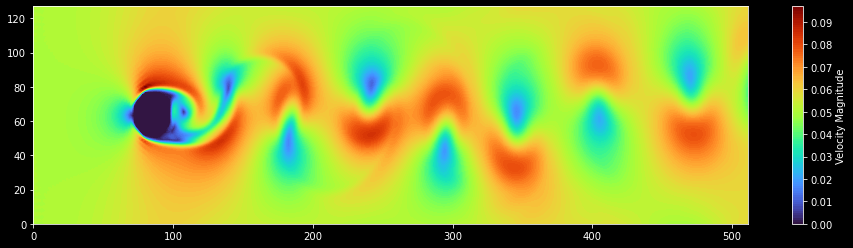

In [26]:
#Main time loop 
for time in tqdm(range(maxIter)):
    # Right wall: outflow condition.
    fin[col3, -1, :] = fin[col3, -2, :]

    # Compute macroscopic variables, density and velocity.
    rho, u = macroscopic(fin)

    # Left wall: inflow condition.
    u[:, 0, :] = vel[:, 0, :]
    rho[0, :] = 1/(1-u[0, 0, :]) * (sum(fin[col2, 0, :], axis=0) +
                                    2*sum(fin[col3, 0, :], axis=0))
    # Compute equilibrium.
    feq = equilibrium(rho, u)
    fin[[0, 1, 2], 0, :] = feq[[0, 1, 2], 0, :] + \
        fin[[8, 7, 6], 0, :] - feq[[8, 7, 6], 0, :]

    # Collision step.
    fout = fin - omega * (fin - feq)

    # Bounce-back condition for obstacle.
    for i in range(9):
        fout[i, obstacle] = fin[8-i, obstacle]

    # Streaming step.
    for i in range(9):
        fin[i, :, :] = roll(
            roll(fout[i, :, :], v[i, 0], axis=0),
            v[i, 1], axis=1)

    # Visualization of the velocity.
    plt.style.use("dark_background")
    if (time % 100 == 0):
        plt.clf()
        velfield = sqrt(u[0]**2+u[1]**2).transpose()
        for i in range(128):
            for j in range(512):
                if obstacle.T[i, j] == True:
                    velfield[i, j] = 0
        plt.contourf(velfield, 100, cmap="turbo")
        plt.colorbar().set_label("Velocity Magnitude")
        #plt.gca().add_patch(plt.Circle((cx, cy), r, color="black"))
        plt.savefig(os.path.join(
            "..", "lbsim cldr", "Original", "imgdata", "vel.{0:04d}.png".format(time//100)))

        # plt.show()

        def write_csv(filename):
            import csv

            f = open(filename, 'w', newline='')
            for velocity in velfield:
                csv.writer(f).writerow(velocity)
            f.close()

        write_csv(os.path.join(
            "..", "lbsim cldr", "Original", "csvdata", "vel.{0:04d}.csv".format(time//100)))
